In [ ]:
!pip install langchain
!pip install langchain_openai


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 904.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.7/407.7 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/3

In [59]:
!pip install git+https://github.com/VarunGumma/IndicTransToolkit.git

  Cloning https://github.com/VarunGumma/IndicTransToolkit.git to /tmp/pip-req-build-hbl7pn6p
  Running command git clone --filter=blob:none --quiet https://github.com/VarunGumma/IndicTransToolkit.git /tmp/pip-req-build-hbl7pn6p
  Resolved https://github.com/VarunGumma/IndicTransToolkit.git to commit 0c607654e8b6cce897a32039df79018a1daff4e2
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/VarunGumma/indic_nlp_library to /tmp/pip-install-qnc_1ru1/indic-nlp-library-it2_bcf48d959d694305982f3fd1ccc35429
  Running command git clone --filter=blob:none --quiet https://github.com/VarunGumma/indic_nlp_library /tmp/pip-install-qnc_1ru1/indic-nlp-library-it2_bcf48d959d694305982f3fd1ccc35429
  Resolved https://github.com/VarunGumma/indic_nlp_library to commit 601521e05ed0ed8f2165ac317a47d186e25b6f0d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 5

In [ ]:
import os
from google.colab import userdata

os.environ['OPENAI_API_KEY'] = userdata.get('OpenAI_Key1')

In [64]:
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI

from IndicTransToolkit import IndicEvaluator
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cosine
import numpy as np

In [78]:
# Define a structured output using Pydantic
class Translation(BaseModel):
    orig_text: str = Field(description="Original Text")
    tran_text: str = Field(description="Translation of the original text")

# Set up the parser using the Pydantic object
parser = PydanticOutputParser(pydantic_object=Translation)

# Set up the model
model = ChatOpenAI(temperature=0.75, top_p = 0.9, model_name="gpt-4o-mini")

In [39]:
# Define the prompt template
prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", 'You are an expert translator. Translate the {src_lang} text to {tar_lang} with utmost care. Return the result as a valid JSON object: {{"orig_text": "{text}", "tran_text": "<translated_text>"}}'),
        ("human", "{text}")
    ]
)

In [79]:
def translate(sents, src, tar):
  results = []
  for sent in sents:
    # Define the prompt invocation
    prompt = prompt_template.format_messages(
    src_lang=src, tar_lang=tar, text=sent)

    # Call the model with the prompt and parser
    response = model(messages=prompt)
    parsed_response = parser.parse(response.content)

    results.append(parsed_response.tran_text)
  return results


def cosine_similarity(original, translated):
    vectorizer = TfidfVectorizer().fit([original, translated])
    vectors = vectorizer.transform([original, translated]).toarray()
    return 1 - cosine(vectors[0], vectors[1])

def evaluate_bleu(lang, pred, ref):
  evaluator = IndicEvaluator()
  scores = evaluator.evaluate(tgt_lang=lang, preds=pred, refs=ref)
  return round(float(scores['bleu']['score']/100),3)

In [63]:
original_sents = [
    "When I will grow up, I will be a doctor.",
    "They have many pets because they are rich and don't have any kids.",
    "I can't stand the smell of garbage.",
    "She is very hardworking and intelligent, which is why she got all the good marks.",
    "We read a new book last week, which was very inspiring.",
    "If you had met me at that time, we would have gone out to eat.",
    "She went to the market with her sister to buy a new sari.",
    "Raj told me that he is going to his grandmother's house next month.",
    "All the kids were having fun at the party and were eating lots of sweets.",
    "My friend has invited me to his birthday party, and I will give him a gift."]

In [81]:
num_iterations = 20
en_sents = original_sents.copy()

as_bleu_scores = []
as_similarity_scores = []

for iteration in range(num_iterations):
    print("Sentences getting translated:", en_sents)
    print()
    print(f"Iteration {iteration + 1}:")

    # English to Assamese
    as_translations = translate(en_sents, src='English', tar='Assamese')

    # Translate back from Assamese to English
    en_translations = translate(as_translations, src='Assamese', tar='English')

     #  BLEU score
    bleu_score = evaluate_bleu(lang='eng_Latn', pred=en_translations, ref=original_sents)
    as_bleu_scores.append(bleu_score)
    print(f"BLEU Score: {bleu_score}")

    # Cosine Similarity
    sims = [cosine_similarity(orig, trans) for orig, trans in zip(original_sents, en_translations)]
    avg_sim = np.mean(sims)
    as_similarity_scores.append(round((avg_sim), 3))
    print(f"Average Similarity Score: {avg_sim:.3f}")
    print("Assamese Translations:", as_translations)
    print("English Back Translations:", en_translations)
    print()

    # Update en_sents to en_translations as the new input
    en_sents = en_translations

# Output the BLEU scores and loss values for each iteration
print("BLEU Scores over iterations:", as_bleu_scores)
print("Similarity Values over iterations:", as_similarity_scores)

Sentences getting translated: ['When I will grow up, I will be a doctor.', "They have many pets because they are rich and don't have any kids.", "I can't stand the smell of garbage.", 'She is very hardworking and intelligent, which is why she got all the good marks.', 'We read a new book last week, which was very inspiring.', 'If you had met me at that time, we would have gone out to eat.', 'She went to the market with her sister to buy a new sari.', "Raj told me that he is going to his grandmother's house next month.", 'All the kids were having fun at the party and were eating lots of sweets.', 'My friend has invited me to his birthday party, and I will give him a gift.']

Iteration 1:
BLEU Score: 0.552
Average Similarity Score: 0.693
Assamese Translations: ["যেতিয়া মই ডাঙৰ হ'ব, মই এজন ডাক্তৰ হ'ব.", 'তেওঁলোকৰ বহুত পেট আছে কাৰণ তেওঁলোকে ধনী আৰু কোনো সন্তান নাই।', 'মই আবর্জনাৰ গন্ধ সহ্য কৰিব নোৱাৰোঁ।', 'তেওঁ অতি পৰিশ্ৰমী আৰু বুদ্ধিমান, যাৰ বাবে তেওঁ সকলো ভাল নম্বৰ লাভ কৰিছে।', 'আমাৰ আগ

In [82]:
num_iterations = 20
en_sents = original_sents.copy()

hin_bleu_scores = []
hin_similarity_scores = []

for iteration in range(num_iterations):
    print("Sentences getting translated:", en_sents)
    print()
    print(f"Iteration {iteration + 1}:")

    # English to Assamese
    hin_translations = translate(en_sents, src='English', tar='Hindi')

    # Translate back from Assamese to English
    en_translations = translate(hin_translations, src='Hindi', tar='English')

     #  BLEU score
    bleu_score = evaluate_bleu(lang='eng_Latn', pred=en_translations, ref=original_sents)
    hin_bleu_scores.append(bleu_score)
    print(f"BLEU Score: {bleu_score}")

    # Cosine Similarity
    sims = [cosine_similarity(orig, trans) for orig, trans in zip(original_sents, en_translations)]
    avg_sim = np.mean(sims)
    hin_similarity_scores.append(round((avg_sim), 3))
    print(f"Average Similarity Score: {avg_sim:.3f}")
    print("Hindi Translations:", hin_translations)
    print("English Back Translations:", en_translations)
    print()

    # Update en_sents to en_translations as the new input
    en_sents = en_translations

# Output the BLEU scores and loss values for each iteration
print("BLEU Scores over iterations:", hin_bleu_scores)
print("Similarity Values over iterations:", hin_similarity_scores)

Sentences getting translated: ['When I will grow up, I will be a doctor.', "They have many pets because they are rich and don't have any kids.", "I can't stand the smell of garbage.", 'She is very hardworking and intelligent, which is why she got all the good marks.', 'We read a new book last week, which was very inspiring.', 'If you had met me at that time, we would have gone out to eat.', 'She went to the market with her sister to buy a new sari.', "Raj told me that he is going to his grandmother's house next month.", 'All the kids were having fun at the party and were eating lots of sweets.', 'My friend has invited me to his birthday party, and I will give him a gift.']

Iteration 1:
BLEU Score: 0.683
Average Similarity Score: 0.775
Hindi Translations: ['जब मैं बड़ा हो जाऊंगा, मैं डॉक्टर बनूंगा।', 'उनके पास कई पालतू जानवर हैं क्योंकि वे अमीर हैं और उनके कोई बच्चे नहीं हैं।', 'मुझे कूड़े की गंध बर्दाश्त नहीं होती।', 'वह बहुत मेहनती और बुद्धिमान है, यही वजह है कि उसे सभी अच्छे अंक मिल

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline

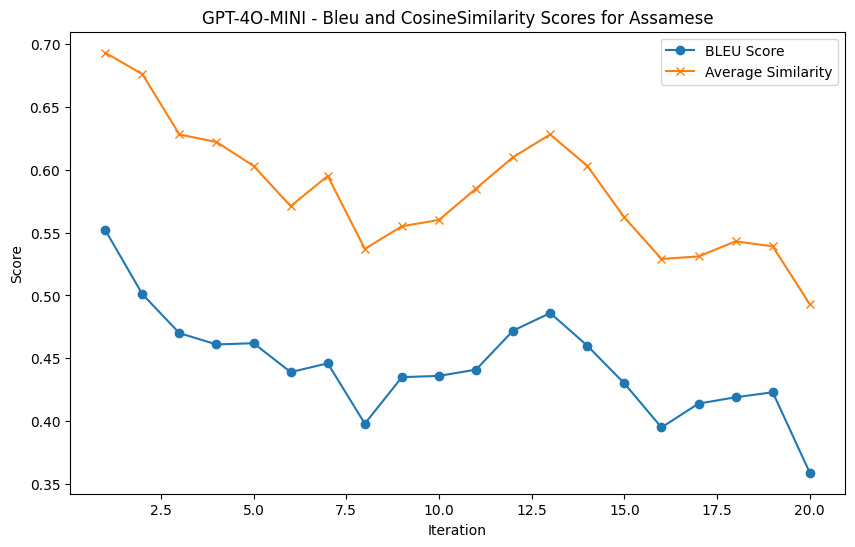

In [85]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, num_iterations + 1), as_bleu_scores, marker='o', linestyle='-', label='BLEU Score')
ax.plot(range(1, num_iterations + 1), as_similarity_scores, marker='x', linestyle='-', label='Average Similarity')
ax.set_xlabel('Iteration')
ax.set_ylabel('Score')
ax.set_title('GPT-4O-MINI - Bleu and CosineSimilarity Scores for Assamese')
ax.legend()

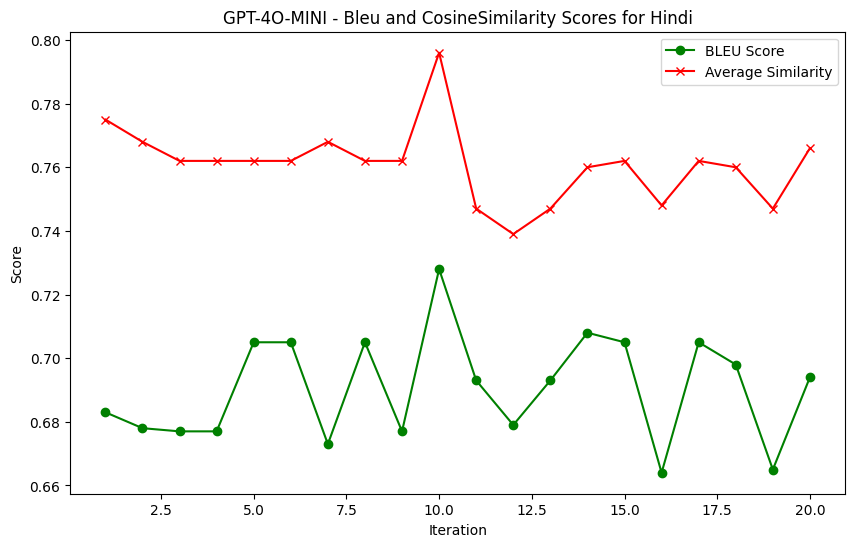

In [86]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, num_iterations + 1), hin_bleu_scores, marker='o', linestyle='-', label='BLEU Score', color='green')
ax.plot(range(1, num_iterations + 1), hin_similarity_scores, marker='x', linestyle='-', label='Average Similarity', color='red')
ax.set_xlabel('Iteration')
ax.set_ylabel('Score')
ax.set_title('GPT-4O-MINI - Bleu and CosineSimilarity Scores for Hindi')
ax.legend()